# ICT707 Task 3 - Part 1 


### Instructions

* Follow instructions on 'Google Colab for Task3.doc' for running this notebook:


* 1.	Visit and log in to Google Colab site: https://colab.research.google.com/
* 2.	Download this notebook from Blackboard and then upload it to Colab
* 3. 	Run “PySpark Environment Setting” cell to get spark and pySpark installed.
* 4.	Type in your NAME and ID in the first coding cell.
* 5.	Place the data files on the correct GDrive folder - 'Colab Notebooks'.
* 6. 	Run the first cell of “Connect GDrive for data set files” to mount GDrive as the storage of data files. Follow the instruction to complete the authorization of using GDrive. 
* 7.    Run Imports
* 8.    Create Spark Session
* 9.    Load CSV file and test

* **After you finish, make sure all cells are executed. Go to menu "File->Download .ipynb" to download your work as 2 files: (1) a Jupyter notebook file and (2) a HTML file. And then submit both files to Blackboard.**

* If you see any error related to spark context, please **run the last cell** and then retry. Or reload the notebook and install the PySpark environment.

## 0 Task 3 Setup
### 1 PySpark Environment Setting

In [1]:
# Please run this cell to get Java and spark installed
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install pyspark==2.4.7

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"


Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,367 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://se

###  Add data file

In [2]:
# Make sure you have relevant data files uploaded, replace 'text_file_name.csv' with your csv file
# And then use the correct data file names below
datafile = "/content/gdrive/My Drive/Colab Notebooks/police_killings.csv"

###  Connect GDrive for data set files

In [3]:
# Mount the cloud folder for data file storage
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


###  Run Imports

In [4]:
# Imports utilised
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression 
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import matplotlib.pyplot as plt 

###  Create Spark Session

In [5]:
# Create Spark Session

sc = SparkSession.builder\
        .master('local[*]') \
        .appName('ICT707_Task3') \
        .getOrCreate()


###  Load CSV File

In [6]:
# file should display the head() records without errors 
# Loading csv file for PySpark and Python 3
data = sc.read.csv(datafile, inferSchema = True, header = True)
data.head()

Row(name="A'donte Washington", age=16, gender='Male', raceethnicity='Black', month='February', day=23, year=2015, city='Millbrook', state='AL', state_fp=1, county_fp=51, tract_ce=30902, county_id=1051, share_white=60.5, share_black=30.5, comp_income=0.937935946)

## 1 Exploratory Data Analysis
##### • telling its number of rows and columns,
##### • doing the data cleaning (missing values or duplicated records) if necessary
##### • selecting 3 columns, and drawing 1 plot (e.g. bar chart, histogram, boxplot, etc.) for each to summarise it

In [7]:
# To be able to visualise the data, the dataframe must be transferred to pandas
data_pandas = data.toPandas()

### 1.1 EDA - Description

In [8]:
# telling its number of rows and columns,

no_rows = data.count()
print("Number of rows are: ", no_rows)

no_cols = len(data.columns)
print('Number of Columns are: ', no_cols)

Number of rows are:  39
Number of Columns are:  16


### 1.2 EDA - Cleaning

In [9]:
# doing the data cleaning (missing values or duplicated records) if necessary

df1 = data.groupby(["name", "age", "gender", "raceethnicity", "month", "day", "year", "city", "state", "state_fp", "county_fp", "tract_ce", "county_id", "share_white", "share_black", "comp_income"]).count().filter("count > 1")
print("Number of Duplicated rows: ", df1.count())

Number of Duplicated rows:  0


### 1.3 EDA - Graphs

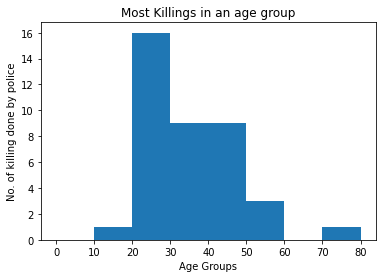

In [10]:
#selecting 3 columns, and drawing 1 plot (e.g. bar chart, histogram, boxplot, etc.) for each to summarise it
# graph 1

#import pandas
import matplotlib.pyplot as plt

plt.hist(data_pandas["age"], bins =[0,10,20,30,40,50,60,70,80],  histtype="bar")
plt.xlabel("Age Groups")
plt.ylabel("No. of killing done by police")
plt.title("Most Killings in an age group")
plt.show()

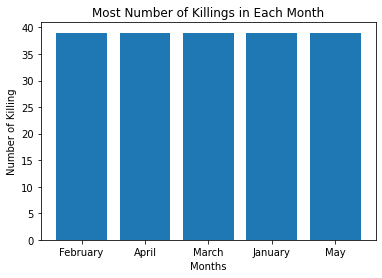

In [11]:
# graph 2

plt.bar(data_pandas["month"].unique(), data_pandas['month'].count())
plt.xlabel("Months")
plt.ylabel("Number of Killing")
plt.title("Most Number of Killings in Each Month")
plt.show()

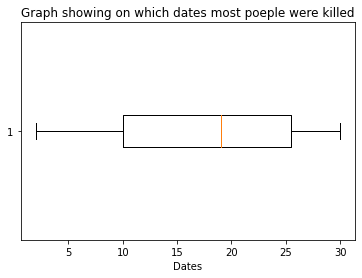

In [12]:
# graph 3

plt.boxplot(data_pandas['day'], vert=False)
plt.xlabel("Dates")
plt.title("Graph showing on which dates most poeple were killed")
plt.show()

## 2 Recommendation Engine
#### This subtask requires you to implement a recommender system on Collaborative filtering with Alternative Least Squares Algorithm. 
#### You need to include
##### • Model training and predictions
##### • Model evaluation using MSE

In [13]:
# Splitting the data into Training and Test data that is used for both Task I.2 and Task I.3
# hint: training_data, testing_data = data.randomSplit([???,???])

training, test = data.randomSplit([0.7, 0.3])

In [14]:
#Recommendation system using Alternative Least Squares Algorithm
# hint: als = ALS(maxIter=??,regParam=??,userCol = "???", itemCol = "???", ratingCol = "???", coldStartStrategy = "???")
# hint: model = als.fit(???)
als=ALS(maxIter=5,regParam=5,userCol="age",itemCol="state_fp",ratingCol="year",coldStartStrategy="drop")
model=als.fit(training)
model.recommendForAllUsers(4).show()

+---+--------------------+
|age|     recommendations|
+---+--------------------+
| 31|[[18, 2014.8064],...|
| 76|[[12, 2080.7507],...|
| 26|[[12, 2036.6925],...|
| 27|[[13, 2014.499], ...|
| 44|[[48, 2014.7528],...|
| 22|[[12, 2080.7507],...|
| 16|[[1, 2014.6816], ...|
| 57|[[12, 2080.7507],...|
| 54|[[51, 2014.8064],...|
| 48|[[12, 2014.8066],...|
| 41|[[13, 2014.7532],...|
| 39|[[47, 2014.8064],...|
| 25|[[13, 2014.499], ...|
| 29|[[4, 2014.8066], ...|
| 21|[[12, 2112.46], [...|
| 32|[[12, 2080.7507],...|
| 33|[[48, 2014.7528],...|
| 30|[[48, 2014.7528],...|
| 36|[[51, 2313.0522],...|
+---+--------------------+



In [15]:
#Evaluate the model using Mean Square Error
# hint: predictions = model.transform(????)
# hint: evaluator = RegressionEvaluator(?????)
# hint: mse = evaluator.evaluate(????)
predictions=model.transform(test)
evaluator= RegressionEvaluator(metricName="mse",labelCol="state_fp",predictionCol="prediction")
mse = evaluator.evaluate(predictions)
print(mse)

9253.173474341194


## 3 Classification
#### This subtask requires you to implement a classification system with Logistic regression. 
#### You need to include
##### • Logistic Regression model training
##### • Model evaluation


In [16]:
# Logistic Regression
# hint: assembler = VectorAssembler().setInputCols([???????,????]).setOutputCol(????)
# hint: train_vector = assembler.transform(?????)
from pyspark.ml.feature import StringIndexer

gender_indexer = StringIndexer(inputCol="gender", outputCol="genderIndex")
data = gender_indexer.fit(data).transform(data)

race_indexer = StringIndexer(inputCol="raceethnicity", outputCol="raceethnicityIndex")
data = race_indexer.fit(data).transform(data)

month_indexer = StringIndexer(inputCol="month", outputCol="monthIndex")
data = month_indexer.fit(data).transform(data)

state_indexer = StringIndexer(inputCol="state", outputCol="stateIndex")
data = state_indexer.fit(data).transform(data)

data.show()


+--------------------+---+------+---------------+--------+---+----+--------------------+-----+--------+---------+--------+---------+-----------+-----------+-----------+-----------+------------------+----------+----------+
|                name|age|gender|  raceethnicity|   month|day|year|                city|state|state_fp|county_fp|tract_ce|county_id|share_white|share_black|comp_income|genderIndex|raceethnicityIndex|monthIndex|stateIndex|
+--------------------+---+------+---------------+--------+---+----+--------------------+-----+--------+---------+--------+---------+-----------+-----------+-----------+-----------+------------------+----------+----------+
|  A'donte Washington| 16|  Male|          Black|February| 23|2015|           Millbrook|   AL|       1|       51|   30902|     1051|       60.5|       30.5|0.937935946|        0.0|               2.0|       1.0|       5.0|
|      Aaron Rutledge| 27|  Male|          White|   April|  2|2015|           Pineville|   LA|      22|       79

In [17]:
splits = data.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [18]:
assembler = VectorAssembler().setInputCols(["raceethnicityIndex", "monthIndex", "day", "stateIndex"]).setOutputCol("feature")
train_vector = assembler.transform(train_df)
train_vector.show()

+--------------------+---+------+---------------+--------+---+----+-------------+-----+--------+---------+--------+---------+-----------+-----------+-----------+-----------+------------------+----------+----------+-------------------+
|                name|age|gender|  raceethnicity|   month|day|year|         city|state|state_fp|county_fp|tract_ce|county_id|share_white|share_black|comp_income|genderIndex|raceethnicityIndex|monthIndex|stateIndex|            feature|
+--------------------+---+------+---------------+--------+---+----+-------------+-----+--------+---------+--------+---------+-----------+-----------+-----------+-----------+------------------+----------+----------+-------------------+
|  A'donte Washington| 16|  Male|          Black|February| 23|2015|    Millbrook|   AL|       1|       51|   30902|     1051|       60.5|       30.5|0.937935946|        0.0|               2.0|       1.0|       5.0| [2.0,1.0,23.0,5.0]|
|      Aaron Rutledge| 27|  Male|          White|   April|  

In [19]:
train_vector = train_vector.select(["feature", "genderIndex",])
train_vector.show()

+-------------------+-----------+
|            feature|genderIndex|
+-------------------+-----------+
| [2.0,1.0,23.0,5.0]|        0.0|
| [0.0,2.0,2.0,18.0]|        0.0|
|[0.0,0.0,14.0,15.0]|        0.0|
|[0.0,0.0,19.0,13.0]|        0.0|
|  [0.0,0.0,7.0,8.0]|        0.0|
| [1.0,0.0,26.0,0.0]|        0.0|
|  [0.0,1.0,7.0,9.0]|        0.0|
| [1.0,1.0,20.0,2.0]|        0.0|
| [0.0,1.0,25.0,3.0]|        0.0|
| [1.0,4.0,30.0,4.0]|        0.0|
| [2.0,2.0,30.0,1.0]|        1.0|
|[1.0,4.0,19.0,19.0]|        0.0|
|     (4,[2],[17.0])|        1.0|
| [2.0,3.0,26.0,0.0]|        0.0|
| [1.0,1.0,26.0,0.0]|        0.0|
| [2.0,3.0,7.0,10.0]|        0.0|
|     (4,[2],[13.0])|        0.0|
| [0.0,0.0,17.0,7.0]|        0.0|
| [0.0,2.0,23.0,0.0]|        0.0|
| [2.0,0.0,6.0,14.0]|        0.0|
+-------------------+-----------+
only showing top 20 rows



In [20]:
# Create the Logistic Regression Model and train it
# hint: lr = LogisticRegression()
# hint: lr_model = lr.fit(?????)

lr = LogisticRegression(featuresCol='feature',labelCol="genderIndex", maxIter=30)
lr_model = lr.fit(train_vector)

In [21]:
# Test the model
# hint: test_vector = assembler.transform(testing)
# hint: test_vector = test_vector.select("features", "label")
# hint: test_vector = lr_model.transform(test_vector)
# hint:

test_vector = assembler.transform(test_df)
test_vector = lr_model.transform(test_vector)
test_vector = test_vector.select("prediction","genderIndex","feature")
test_vector.show()

+----------+-----------+-------------------+
|prediction|genderIndex|            feature|
+----------+-----------+-------------------+
|       0.0|        0.0| [1.0,0.0,11.0,0.0]|
|       0.0|        0.0| [1.0,0.0,27.0,0.0]|
|       0.0|        0.0| [0.0,3.0,28.0,2.0]|
|       0.0|        0.0| [0.0,2.0,26.0,0.0]|
|       0.0|        0.0| [0.0,4.0,12.0,0.0]|
|       0.0|        0.0|  [0.0,2.0,6.0,3.0]|
|       0.0|        0.0|[1.0,1.0,13.0,11.0]|
|       0.0|        0.0|[0.0,2.0,29.0,12.0]|
|       0.0|        0.0|[0.0,3.0,21.0,17.0]|
|       0.0|        0.0| [2.0,4.0,25.0,5.0]|
|       0.0|        0.0|  [0.0,1.0,3.0,1.0]|
|       0.0|        0.0| [1.0,0.0,12.0,0.0]|
+----------+-----------+-------------------+



In [22]:
# Model Evaluation using Root Mean Square Error (RMSE)
# hint: rmse_test = evaluator.evaluate(?????, {evaluator.metricName: "rmse"})
# hint: rmse_train = evaluator.evaluate(?????, {evaluator.metricName: "rmse"})
#print("RMSE for Test:",rmse_test)
#print("RMSE for Train:",rmse_train)

lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="genderIndex",metricName="rmse")
rmse_test = lr_evaluator.evaluate(test_vector)

print("RMSE for Test:",rmse_test)

RMSE for Test: 0.0


## Shut down SparkContext when exiting

If you have error messages related to sparkContext, try to run the following cell, and then rerun all cells.

In [23]:
sc.stop()